In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import scipy.optimize as sci_opt

<h2><b>Portfolio Optimization Project: Monte Carlo Simulation and Optimization with SciPy in the Saudi Market</b></h2>

<h4><b>Introduction:</b></h4>

<p>In this project, we employ a quantitative approach to portfolio optimization by leveraging Monte Carlo simulations alongside mathematical programming methods from SciPy. Our goal is to identify two optimized portfolio configurations: one that maximizes the Sharpe ratio, achieving the highest return per unit of risk, and another that minimizes portfolio volatility.

Using Monte Carlo simulation, we generate numerous random portfolio compositions to understand the range of possible risk-return outcomes based on historical data. Following this, we apply SciPy's optimization methods to solve for portfolios that meet specific objectives—maximizing the Sharpe ratio and minimizing volatility. This approach allows us to construct robust portfolio choices that balance the trade-off between risk and return, guided by statistical and optimization techniques.</p>

In [3]:
#define the stocks in a list
stocks_list = ["2222.SR", "1120.SR", "7010.SR", "1180.SR", "2010.SR", "1150.SR", "2380.SR" , "1211.SR", "7010.SR", "SECO.SR"]


#download the stocks using the yahoo finance library
stock_data = yf.download(stocks_list, start = "2019-12-31", end = "2024-12-31")

stock_data = stock_data.rename(columns = {"Adj Close": "adj_close"})

stock_data = stock_data.stack()

stock_data["ticker"] = stock_data.index.get_level_values("Ticker").astype(str)

stock_data = stock_data.droplevel(level = "Ticker")

stock_data






[*********************100%***********************]  9 of 9 completed

1 Failed download:
['SECO.SR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
C:\Users\pc\AppData\Local\Temp\ipykernel_16516\1652873699.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stock_data = stock_data.stack()


Price,adj_close,Close,High,Low,Open,Volume,ticker
Date,,,,,,,
2019-12-31 00:00:00+00:00,36.571590,40.875000,41.000000,40.562500,40.812500,7184065.0,1120.SR
2019-12-31 00:00:00+00:00,13.623671,15.210003,15.210003,14.892003,14.928003,17733597.0,1150.SR
2019-12-31 00:00:00+00:00,30.923782,36.937500,37.049999,36.562500,37.049999,1842314.0,1180.SR
2019-12-31 00:00:00+00:00,14.800000,14.800000,14.800000,14.600000,14.733333,923991.0,1211.SR
2019-12-31 00:00:00+00:00,75.532028,93.900002,94.000000,93.199997,93.699997,1394747.0,2010.SR
...,...,...,...,...,...,...,...
2024-11-06 00:00:00+00:00,56.200001,56.200001,57.200001,54.200001,54.200001,3020077.0,1211.SR
2024-11-06 00:00:00+00:00,72.500000,72.500000,72.800003,72.199997,72.599998,1057377.0,2010.SR
2024-11-06 00:00:00+00:00,27.549999,27.549999,27.549999,27.350000,27.549999,16718090.0,2222.SR


According to the download results, it seems like we will not be including SECO.SR (Saudi Electronics Company) into our portfolio because the download failed due to no timezone being found.

In [4]:
#ensure that no null values exist within the dataframe
print(stock_data.isnull().sum())
#gather the successfully downloaded stocks

assets_list = stock_data["ticker"].unique()

n_assets = len(assets_list)

stock_df = stock_data[["ticker", "adj_close"]]

stock_df = stock_df.pivot(columns = "ticker",
                          values = "adj_close")



Price
adj_close    0
Close        0
High         0
Low          0
Open         0
Volume       0
ticker       0
dtype: int64


### **What is the Sharpe Ratio?**

The Sharpe ratio is used as a measure for calculating risk-adjusted return and has been the industry standard for such calculations. It allows us to quantify the relationship of average return earned in excess of the risk-free rate per unit of volatility or total risk.

#### **Sharpe Ratio Formula:**

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where:
- \( R_p \) is the return of the portfolio
- \( R_f \) is the risk-free rate of return
- \( \sigma_p \) is the standard deviation of the portfolio’s excess return (volatility)

To calculate expected returns, we use the following portfolio return formula:

$$
R_p = \sum_{i=1}^{n} w_i \cdot R_i
$$

where:
- \( R_p \) is the total portfolio return
- \( n \) is the number of assets in the portfolio
- \( w_i \) is the weight of asset \( i \) in the portfolio (based on capital allocation)
- \( R_i \) is the return of asset \( i \)

The formula for the portfolio standard deviation (risk) is:

$$
\sigma_p = \sqrt{\sum_{i=1}^{n} w_i^2 \cdot \sigma_i^2 + \sum_{i=1}^{n} \sum_{j \neq i} w_i \cdot w_j \cdot \sigma_i \cdot \sigma_j \cdot \rho_{ij}}
$$

where:
- \( \sigma_p \) is the portfolio standard deviation
- \( n \) is the number of assets in the portfolio
- \( w_i \) is the weight of asset \( i \) in the portfolio
- \( \sigma_i \) is the standard deviation of asset \( i \)
- \( \rho_{ij} \) is the correlation between assets \( i \) and \( j \)




In [5]:
#calculate the log of returns
log_return = np.log1p(stock_df.pct_change())


#Generate Random Weights

random_weights = np.array(np.random.random(n_assets))

#Rebalance the weights so that all of them equals to 1

rebalanced_weights = random_weights / sum(random_weights)

#Calculate the expected returns annually

expected_returns = np.sum(log_return.mean() * rebalanced_weights) * 365

#calculate the Expected Volatility annually 

expected_volatility = np.sqrt(
    
    np.dot(
        rebalanced_weights.T,
        np.dot(
            log_return.cov() * 365,
            rebalanced_weights
        )
    )
)

#Calculate the sharpe ratio

sharpe_ratio = (expected_returns - 0.01) / expected_volatility


#create a dataframe for the weights

weights_df = pd.DataFrame(data = 
                          {"random_weights": random_weights,
                           "weights_rebalanced": rebalanced_weights,
                           
})


print("Portfolio Weights:")

display(weights_df)

print("_" * 100)
#create a dataframe for the financial metrics we just computed

metrics_df = pd.DataFrame(data = {"expected_returns" : [expected_returns],
                                  "expected_volatility" :[expected_volatility],
                                  "sharpe_ratio" : [sharpe_ratio],
})

print("Financial Metrics:")

display(metrics_df)

print("_"*100)



Portfolio Weights:


C:\Users\pc\AppData\Local\Temp\ipykernel_16516\1402707014.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  log_return = np.log1p(stock_df.pct_change())


,random_weights,weights_rebalanced
0,0.112022,0.041728
1,0.375233,0.139774
2,0.138905,0.051742
3,0.119084,0.044359
4,0.264379,0.098481
5,0.881151,0.328229
6,0.717794,0.267378
7,0.075995,0.028308


____________________________________________________________________________________________________
Financial Metrics:


,expected_returns,expected_volatility,sharpe_ratio
0,0.024828,0.23055,0.064315


____________________________________________________________________________________________________


In [6]:
metrics_df["expected_returns"] * 100

0    2.48279
Name: expected_returns, dtype: float64

Interpreting the portfolio's current metrics will help set a foundation before proceeding with more advanced analyses like Monte Carlo simulations. Let’s go over each metric to understand the portfolio's initial performance and potential implications.


<b>NOTE: Keep in mind that those results can change everytime we run the model due to the change of randomized weights from our code. However, the changes are still close to the conclusion.</b>
<hr>

<h4><b>Expected Returns (0.024828):</b></h4>

<p><b>Interpretation:</b> This represents the anticipated return for the portfolio, which is about 2.48% annually..</p>

<p><b>Further Insights:</b> Achieving this return in a risk-conscious way, especially if it surpasses any benchmarks, shows that the portfolio can be expected to grow significantly over time. However, one might view this as an indication that their portfolio needs revisiting to ensure it aligns with their return expectations.</p>

<h4><b>Expected Volatility (0.23055):</b></h4>

<p><b>Interpretation:</b> This reflects the portfolio's annualized standard deviation of returns, meaning the expected variability in returns is around 23.055%.

<b>Further Insights:</b> This level of risk might or might not be acceptable depending on an investor's risk tolerance. High volatility portfolios may not be suitable for risk-averse clients or those with shorter investment horizons.</p>

<h4><b>Sharpe Ratio (0.064315):</b></h4>

<p><b>Interpretation:</b> The Sharpe ratio measures the portfolio’s risk-adjusted return. A ratio of 0.064315 means that for every unit of risk, the portfolio is expected to deliver about 0.51 units of excess return (i.e., returns above the risk-free rate).

<b>Further Insights:</b> While a Sharpe ratio above 1 is generally considered strong, this value suggests a moderate risk-adjusted return. The portfolio's performance could be improved by increasing the Sharpe ratio (if possible) through further optimization or by identifying assets with better risk-return profiles.</p>
<hr>
<hr>

<h2><b>Monte Carlo Simulations</b></h2>


Previously we have calculated the expected returns, expected volatility, and then we used the sharpe ratio to quantify how well the portfolio is allocated based on risk perspective. Now that we know we want a higher sharpe ratio , what is the portfolio allocation to achieve this?

Monte Carlo Simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk uncertainity  in prediction and forecasting models.


In [7]:
#Define a Monte Carlo Sim function

def simulate_portfolios(adj_close_df, assets, n_sims = 6000):

    #define the Weight array 
    all_weights = np.zeros((n_sims, assets))

    #define the returns array
    return_arr = np.zeros(n_sims)

    #define the volatility array
    volatility_arr = np.zeros(n_sims)

    #define the sharpe ratio array

    sharpe_arr = np.zeros(n_sims)

    #simulation

    for ind in range(n_sims):
        #calculate the log of returns
        log_returns = np.log1p(adj_close_df.pct_change())


        #Generate Random Weights

        weights = np.array(np.random.random(assets))
        

        #Rebalance the weights so that all of them equals to 1 and place them into an array for each index

        weights = weights / sum(weights)

        all_weights[ind, :] = weights

        #Calculate the expected returns annually and place them into an array for each index

        return_arr[ind] = np.sum(log_returns.mean() * weights) * 365

        #calculate the Expected Volatility annually and place them into an array for each index

        volatility_arr[ind] = np.sqrt(
    
        np.dot(
            weights.T,
            np.dot(
                log_returns.cov() * 365,
                weights
            )
        )
    )

         #Calculate the sharpe ratio

        sharpe_arr[ind] = (return_arr[ind] - 0.01) / volatility_arr[ind]

    #Combine results into a DataFrame  
    #   
    weights_columns = [f"Weight_{i}" for i in range(assets)]
    simulations_df = pd.DataFrame({
        "Expected Returns": return_arr,
        "Expected Volatility": volatility_arr,
        "Sharpe Ratio": sharpe_arr,
        **{col: all_weights[:, i] for i, col in enumerate(weights_columns)}
    })

    return simulations_df

# Run the simulation
simulations = simulate_portfolios(stock_df, n_assets, n_sims=6000)


C:\Users\pc\AppData\Local\Temp\ipykernel_16516\3073954210.py:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  log_returns = np.log1p(adj_close_df.pct_change())


In [8]:
#rename the columns to the stock names

# Initialize empty dictionary
columns_rename = {}

# Loop through assets_list and generate dictionary entries
for i, asset in enumerate(assets_list):
    columns_rename[f"Weight_{i}"] = asset

simulations = simulations.rename(columns = columns_rename)

#rename the index
simulations = simulations.rename_axis("Portfolio Num")
#grab the minimum volatility
min_volatility = simulations.loc[simulations["Expected Volatility"].idxmin()]
#grab the maximum sharpe ratio
max_sharpe = simulations.loc[simulations["Sharpe Ratio"].idxmax()]

display(min_volatility)
display(max_sharpe)
simulations

Expected Returns       0.062359
Expected Volatility    0.189247
Sharpe Ratio           0.276669
1120.SR                0.091446
1150.SR                0.039734
1180.SR                0.177018
1211.SR                0.015346
2010.SR                0.123514
2222.SR                0.325143
2380.SR                0.022877
7010.SR                0.204921
Name: 2806, dtype: float64

Expected Returns       0.246630
Expected Volatility    0.265306
Sharpe Ratio           0.891914
1120.SR                0.297527
1150.SR                0.252471
1180.SR                0.044111
1211.SR                0.277959
2010.SR                0.057281
2222.SR                0.019802
2380.SR                0.029018
7010.SR                0.021831
Name: 5211, dtype: float64

,Expected Returns,Expected Volatility,Sharpe Ratio,1120.SR,1150.SR,1180.SR,1211.SR,2010.SR,2222.SR,2380.SR,7010.SR
Portfolio Num,,,,,,,,,,,
0,0.101060,0.233377,0.390185,0.139144,0.010023,0.058132,0.183519,0.068290,0.134358,0.191413,0.215121
1,0.093304,0.221730,0.375702,0.103207,0.069454,0.113523,0.136320,0.196591,0.113950,0.112366,0.154589
2,0.113596,0.199174,0.520129,0.034989,0.210978,0.082047,0.081717,0.077942,0.188204,0.022700,0.301424
3,0.055931,0.217470,0.211206,0.033097,0.234612,0.257165,0.005412,0.050720,0.274388,0.118572,0.026034
4,0.090906,0.219193,0.369107,0.118811,0.119910,0.190104,0.097537,0.079098,0.127241,0.133700,0.133601
...,...,...,...,...,...,...,...,...,...,...,...
5995,0.077707,0.222947,0.303694,0.086441,0.188456,0.059616,0.079469,0.055733,0.158450,0.209938,0.161897
5996,0.060888,0.225683,0.225482,0.009674,0.148811,0.119148,0.108498,0.143795,0.158273,0.186123,0.125677
5997,0.147782,0.221517,0.621995,0.119710,0.234933,0.021296,0.143905,0.108294,0.057204,0.076782,0.237876


##  **Monte Carlo Simulation Results Summary**

<b>NOTE: Results may vary depending on the randomized weights and number of simulations conducted.</b>

<hr>


#### **Minimum Volatility Portfolio**

**Expected Return:** Expected Returns are **6.2%** annually, indicating a conservative return. This aligns with the objective of minimizing risk, although it may be below the client’s target if they are aiming for higher returns.6.21% annually, indicating a conservative return. This aligns with the objective of minimizing risk, although it may be below the client’s target if they are aiming for higher returns.

**Expected Volatility:** **18%**, showing that this portfolio is relatively stable and has the lowest expected variation in returns among available options. This is suitable for a client with low risk tolerance.

**Sharpe Ratio:** **0.27**, which is low and implies that the portfolio’s excess return (relative to risk-free rate) is modest. This is a reflection of its conservative nature, focused on minimizing risk rather than maximizing return.

**Overall:** This portfolio is ideal for a conservative investor focused on stability. However, the low Sharpe ratio and expected returns suggest it’s more appropriate for clients prioritizing capital preservation over growth.

<hr>

#### **Maximum Sharpe Ratio Portfolio**

**Expected Return:** **27.16% annually**, which is significantly higher than the minimum volatility portfolio and indicates a strong growth potential.

**Expected Volatility:** **28.38%**, which is higher but justifiable given the potential returns. This portfolio has a greater risk-return trade-off and suits a client with higher risk tolerance.

**Sharpe Ratio:** **0.922**, indicating a high risk-adjusted return. This portfolio is optimized to deliver the most excess return per unit of risk, which is ideal for clients seeking growth while still managing risk effectively.


**Overall:** This portfolio is suitable for clients seeking high risk-adjusted returns, with the potential for substantial gains but with moderate-to-high volatility. Its higher Sharpe ratio indicates that this allocation provides the best excess return for the level of risk assumed.

<hr>

### **Comparison and Recommendations:**

* **For Risk-Averse Clients:** **The Minimum Volatility Portfolio** is ideal, offering stable returns and lower risk, though it’s limited in growth potential.

* **For Growth-Oriented Clients:** The **Maximum Sharpe Ratio Portfolio** offers attractive growth with a well-optimized risk-return balance, making it preferable for clients who can tolerate more volatility in exchange for higher returns.

<hr>
<hr>




### **Plotting:**

We will be using **matplotlib** to create a scatter plot that shows the relationship between the overall volatility of our portfolio, and the expected returns from it. As we observed above, the more we tackle on risk, the more risk-adjusted adjusted returns we can get and vice versa. 

C:\Users\pc\AppData\Local\Temp\ipykernel_16516\91630266.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\pc\AppData\Local\Temp\ipykernel_16516\91630266.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe[1], #displays the expected volatility
C:\Users\pc\AppData\Local\Temp\ipykernel_16516\91630266.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe[0], #displays the expected return
C:\Users\pc\AppData\Local\Temp\ipykernel_16516\91630266.py:30: F

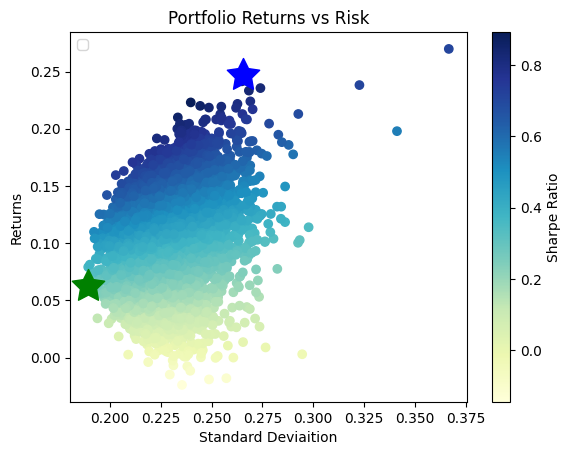

In [15]:
%matplotlib inline

#plot the data into a scatter plot
plt.scatter(y = simulations["Expected Returns"],
             x = simulations["Expected Volatility"],
               c=simulations["Sharpe Ratio"],
               cmap ="YlGnBu"
               
               )
plt.title("Portfolio Returns vs Risk")
plt.colorbar(label = "Sharpe Ratio")
plt.xlabel("Standard Deviaition")
plt.ylabel("Returns")
plt.legend()



#plot the max sharpe ratio using the blue star
plt.scatter(
    max_sharpe[1], #displays the expected volatility
    max_sharpe[0], #displays the expected return
    marker=(5,1,0),
    color="blue",
    s=600
)

#plot the min volatility using the green star

plt.scatter(
    min_volatility[1], #displays the expected volatility
    min_volatility[0], #displays the expected return
    marker=(5,1,0),
    color="green",
    s=600
)

plt.show()

## **Optimizing a Portfolio:**

Our second Portfolio Optimization method consists of using the SciPy Optimization module. As we observed from the first optimization method (which was Monte Carlo Simulations), the method had a huge drawback which was everytime we ran our simulations, our results change due to the randomized weights but still give us the same conclusion. it is not the most efficient way to find optimal values due to the amount of simulations we had to run. This time, we want exact exact results. We will be using mathematical techniques to get ourselves the optimal values for our portfolio.

This technique involves the use of mathematical programming methods to find the maximum and minimum values of our objective function.

In [10]:
#define a function the gets the financial metrics
def get_metrics(weights: list) -> np.array:
    weights = np.array(weights)

    #calculate the expected returns
    returns = np.sum(log_return.mean() * weights) * 365

    #calculate the volatility
    volatility = np.sqrt(
        np.dot(weights.T,
               np.dot(log_return.cov() * 365,
               weights)
    ))

    #calculate the sharpe ratio
    sharpe = returns  / volatility 

    return np.array([returns, volatility, sharpe ])

def grab_negative_sharpe(weights: list) -> np.array: #we are actually maximizing 

    return -get_metrics(weights)[2]

def grab_volatility(weights: list) -> np.array: 
    return get_metrics(weights)[1]

def check_sum_of_weights(weights: list ) -> float:
    return sum(weights) - 1

 



In [11]:
#Define the bounds in our optimization process to ensure the asset weight is not larger than 1(which is the entire portfolio).

bounds = tuple((0,1) for n_asset in range(n_assets))

#define the constraints to ensure the total weights do not exceed 1

constraints = ({"type":"eq", "fun": check_sum_of_weights}) 

#Define the initial guesses
init_guess = n_assets * [1 / n_assets]

#perform the optimization process
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, #what we want to minimize
    init_guess, #initial weights
    method = "SLSQP",
    bounds = bounds,
    constraints = constraints
)

print("Oprimized Sharpe Ratio:")
print("_"* 100)
print(optimized_sharpe)

Oprimized Sharpe Ratio:
____________________________________________________________________________________________________
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0921148378150622
       x: [ 6.550e-01  1.145e-01  7.378e-17  2.305e-01  4.949e-17
            0.000e+00  1.344e-16  0.000e+00]
     nit: 7
     jac: [ 5.126e-06  6.671e-05  6.308e-01 -4.764e-05  6.996e-01
            3.158e-01  1.402e+00  1.469e-01]
    nfev: 64
    njev: 7


In [12]:
#fetch the final results
optimized_metrics  = get_metrics(weights = optimized_sharpe.x)

print("Optimized Metrics:")

print("_"*100)

print(optimized_metrics)

Optimized Metrics:
____________________________________________________________________________________________________
[0.29816445 0.27301566 1.09211484]


In [13]:
#Define the bounds
bounds_vol = tuple((0, 1) for n_asset in range(n_assets))

#check the sum of weights
constraints = ({"type":"eq", "fun": check_sum_of_weights})

#Define the initial guesses
init_guess = n_assets * [1 / n_assets]

#perform the optimization process
optimized_volatility = sci_opt.minimize(
    grab_volatility, 
    init_guess, #initial weights
    method = "SLSQP",
    bounds = bounds,
    constraints = constraints
)

print("Oprimized Volatility:")
print("_"* 100)
print(optimized_volatility)


Oprimized Volatility:
____________________________________________________________________________________________________
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17764183299184294
       x: [ 6.880e-02  8.873e-03  4.209e-02  6.288e-18  1.142e-02
            5.507e-01  1.355e-18  3.181e-01]
     nit: 8
     jac: [ 1.772e-01  1.781e-01  1.773e-01  2.083e-01  1.774e-01
            1.777e-01  1.835e-01  1.777e-01]
    nfev: 72
    njev: 8


In [14]:
#fetch the final results for the optimized volatility
optimized_metrics  = get_metrics(weights = optimized_volatility.x)

print("Optimized Metrics:")

print("_"*100)

print(optimized_metrics)

Optimized Metrics:
____________________________________________________________________________________________________
[0.06142213 0.17764183 0.34576386]


## **Portfolio Metric Results:**

**Maximization of the Sharpe Ratio:**

**Objective Function:**
Maximize: Sharpe Ratio = (E[Rₚ] - R_f) / σₚ

Where:
- E[Rₚ] = Expected return of the portfolio
- R_f = Risk-free rate
- σₚ = Portfolio volatility

This can be rewritten for optimization purposes (minimizing the negative Sharpe ratio):

Maximize: Sharpe Ratio = (wᵀE - R_f) / √(wᵀΣw)

Where:
- E = Vector of expected returns for each asset

**Constraints:**
1. The sum of the weights must equal 1:

∑(wᵢ) = 1

2. Each weight can be bounded between 0 and 1 (if short-selling is not allowed):
0 ≤ wᵢ ≤ 1 for all i

#### **Results:**

- **Expected Returns: 29%**
* An expected return of 29% is quite promising. This indicates that, on average, the portfolio is projected to generate a substantial profit over the investment period. Such returns are typically attractive to investors.
- **Expected Volatility: 27%**
* A volatility of 27% suggests a moderate level of risk. While this is higher than what might be considered "low risk," it's not excessively high. This level of volatility indicates that there could be significant fluctuations in portfolio value, but the expected returns justify this risk in the context of the Sharpe ratio.
- **Sharpe Ratio: 1.0**
* A Sharpe ratio of 1.0711 indicates that the portfolio is expected to deliver positive excess returns per unit of risk. A Sharpe ratio above 1 is generally considered good, suggesting that the portfolio is efficiently balanced between risk and return. This means that the portfolio is not only expected to yield higher returns, but it is also doing so in a way that is efficient relative to the risk taken.

<hr>

**Minimization of the Volatility:**

**Objective Function:**

Minimize: σₚ = √(wᵀΣw)

Where:
- σₚ = Portfolio volatility
- w = Vector of weights (proportions of the total investment in each asset)
- Σ = Covariance matrix of asset returns

**Constraints:**
1. The sum of the weights must equal 1:

∑(wᵢ) = 1

where n is the number of assets.

2. Each weight can be bounded between 0 and 1 (if short-selling is not allowed):


#### **Results:**


- **Expected Returns: 5.7%**
This figure represents the annualized expected return of the portfolio based on the current asset allocation. While a return of 5.7% can be viewed as positive, it is relatively modest, especially compared to some market benchmarks or historical averages.

- **Expected Volatility: 17.78%**
This percentage reflects the standard deviation of the portfolio's returns, indicating the level of risk or uncertainty associated with the portfolio's performance. A volatility of 17.78% suggests that the returns could fluctuate significantly, which could be a concern if the client has a low risk tolerance.

- **Sharpe Ratio: 0.320**
The Sharpe ratio measures the risk-adjusted return of the portfolio. A ratio of 0.315 suggests that the portfolio is generating 0.315 units of excess return for each unit of risk taken. Generally, a Sharpe ratio above 1 is considered good, around 0.5 to 1 is acceptable, and below 0.5 indicates that the returns are not commensurate with the risk.



<h2><b>Conclusion</b></h2>
In this project, we employed Monte Carlo simulations and optimization methods to construct and refine an investment portfolio with the goal of balancing risk and return effectively.

<p><b>Monte Carlo simulations</b> provided a robust, probabilistic approach to portfolio optimization. By generating a large number of random weight combinations, we were able to explore a vast range of potential portfolios, revealing the distribution of expected returns, volatilities, and Sharpe ratios. This approach allowed us to visualize the efficient frontier, identifying portfolios that maximized the Sharpe ratio and minimized volatility, even under uncertain market conditions.</p>

<p><b>Optimization methods</b>, particularly those using mathematical programming, offered a more targeted approach to achieving our portfolio objectives. By setting specific goals—such as maximizing the Sharpe ratio or minimizing volatility—we could mathematically optimize the portfolio weights based on exact calculations, yielding more precise solutions than Monte Carlo simulations alone. This approach is computationally efficient and ensures that portfolio constraints (e.g., weights summing to one, no short selling) are respected.</p>

<p>Together, these two techniques enabled us to balance exploratory analysis with precision. The Monte Carlo method provided insight into the overall risk-return landscape, while optimization helped us pinpoint portfolios that aligned with the client's investment goals and risk tolerance. This dual approach enhances confidence in the portfolio recommendations, offering a solid foundation for achieving optimal performance in varying market conditions.</p>